In [1]:
import pickle
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

In [2]:
DATA_PATH = "/Users/nils/master/Stress-Detection-From-Wearables/data/WESAD"

In [3]:
class Subject:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

In [4]:
s10 = Subject(DATA_PATH, '10')

In [121]:
s10_wrist_data = s10.get_wrist_data()

In [122]:
s10_wrist_data

{'ACC': array([[ 107., -105.,  127.],
        [  67.,  -52.,   45.],
        [  26.,   40.,    0.],
        ...,
        [  54.,   23.,   24.],
        [  54.,   23.,   24.],
        [  54.,   23.,   24.]]),
 'BVP': array([[10.17],
        [12.04],
        [13.01],
        ...,
        [57.59],
        [65.93],
        [69.86]]),
 'EDA': array([[0.349215],
        [0.346656],
        [0.350494],
        ...,
        [0.931574],
        [0.932854],
        [0.932854]]),
 'TEMP': array([[33.13],
        [33.16],
        [33.16],
        ...,
        [30.83],
        [30.83],
        [30.83]])}

# Data Preparation

In [ ]:
# https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py

**Wrist - Empatica E4**

ACC: three-axis acceleration (32 Hz)

BVP: blood volume pulse (64 Hz)

EDA: electrodermal activity (4 Hz)

TEMP: skin temperature (4 Hz)

In [179]:
bvp_signal

array([[10.17],
       [12.04],
       [13.01],
       ...,
       [57.59],
       [65.93],
       [69.86]])

In [220]:
bvp_signal = s10_wrist_data['BVP'][:,0]
eda_signal = s10_wrist_data['EDA'][:,0]
acc_x_signal = s10_wrist_data['ACC'][:,0]
acc_y_signal = s10_wrist_data['ACC'][:,1]
acc_z_signal = s10_wrist_data['ACC'][:,2]
temp_signal = s10_wrist_data['TEMP'][:,0]
labels = s10.labels

In [ ]:
signals, info = nk.eda_process(eda_signal, sampling_rate=4)

nk.eda_plot(signals[:3000], sampling_rate=4)

In [160]:
# Turn e4-wrist-data into datafames

eda_df = pd.DataFrame(s10_wrist_data['EDA'], columns=['EDA'])
bvp_df = pd.DataFrame(s10_wrist_data['BVP'], columns=['BVP'])
acc_df = pd.DataFrame(s10_wrist_data['ACC'], columns=['ACC_x', 'ACC_y', 'ACC_z'])
temp_df = pd.DataFrame(s10_wrist_data['TEMP'], columns=['TEMP'])
label_df = pd.DataFrame(s10.labels, columns=['label'])

In [62]:
eda_df.index

RangeIndex(start=0, stop=21984, step=1)

# Data

In [151]:
fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700}

In [161]:
eda_df.index = [(1 / fs_dict['EDA']) * i for i in range(len(eda_df))]
bvp_df.index = [(1 / fs_dict['BVP']) * i for i in range(len(bvp_df))]
acc_df.index = [(1 / fs_dict['ACC']) * i for i in range(len(acc_df))]
temp_df.index = [(1 / fs_dict['TEMP']) * i for i in range(len(temp_df))]
label_df.index = [(1 / fs_dict['label']) * i for i in range(len(label_df))]

In [162]:
eda_df.index = pd.to_datetime(eda_df.index, unit='s')
bvp_df.index = pd.to_datetime(bvp_df.index, unit='s')
temp_df.index = pd.to_datetime(temp_df.index, unit='s')
acc_df.index = pd.to_datetime(acc_df.index, unit='s')
label_df.index = pd.to_datetime(label_df.index, unit='s')

In [180]:
eda_df

,EDA
1970-01-01 00:00:00.000,0.349215
1970-01-01 00:00:00.250,0.346656
1970-01-01 00:00:00.500,0.350494
1970-01-01 00:00:00.750,0.336423
1970-01-01 00:00:01.000,0.338981
...,...
1970-01-01 01:31:34.750,0.941808
1970-01-01 01:31:35.000,0.940529
1970-01-01 01:31:35.250,0.931574
1970-01-01 01:31:35.500,0.932854


In [168]:
len(bvp_df)

351744

In [79]:
# Combined dataframe - not used yet
df = eda_df.join(bvp_df, how='outer')
df = df.join(temp_df, how='outer')
df = df.join(acc_df, how='outer')
df = df.join(label_df, how='outer')
df['label'] = df['label'].fillna(method='bfill')
df.reset_index(drop=True, inplace=True)

df_test = pd.DataFrame()
df_test = bvp_df.join(label_df, how='inner')

In [159]:
# Combined dataframe - not used yet
df_test = pd.DataFrame()
df_test = bvp_df.join(label_df, how='inner')
df_test = df_test.join(eda_df, how='outer')
df_test = df_test.join(acc_df, how='outer')
# df_test = df_test.join(label_df, how='inner')
#df_test['label'] = df_test['label'].fillna(method='bfill')
#df_test.reset_index(drop=True, inplace=True)

In [177]:
df_test = pd.DataFrame()
df_test = bvp_df.join(label_df, how='left')
#df_test = df_test.join(eda_df, how='inner')

In [178]:
label_df

,label
1970-01-01 00:00:00.000000000,0
1970-01-01 00:00:00.001428571,0
1970-01-01 00:00:00.002857142,0
1970-01-01 00:00:00.004285714,0
1970-01-01 00:00:00.005714285,0
...,...
1970-01-01 01:31:35.992857142,0
1970-01-01 01:31:35.994285714,0
1970-01-01 01:31:35.995714285,0
1970-01-01 01:31:35.997142857,0


In [100]:
len(df[df['label'] == 1])

826000

In [119]:
df[0:176]

,EDA,BVP,TEMP,ACC_x,ACC_y,ACC_z,label
0,0.349215,10.17,33.13,107.0,-105.0,127.0,0
1,NaN,12.04,NaN,NaN,NaN,NaN,0
2,NaN,13.01,NaN,67.0,-52.0,45.0,0
3,NaN,13.07,NaN,NaN,NaN,NaN,0
4,NaN,12.33,NaN,26.0,40.0,0.0,0
...,...,...,...,...,...,...,...
171,NaN,10.68,NaN,NaN,NaN,NaN,0
172,NaN,10.53,NaN,57.0,22.0,17.0,0
173,NaN,10.23,NaN,NaN,NaN,NaN,0
174,NaN,9.77,NaN,56.0,22.0,17.0,0


In [109]:
df.BVP[:351746]

0         10.17
1         12.04
2         13.01
3         13.07
4         12.33
          ...  
351741    57.59
351742    65.93
351743    69.86
351744      NaN
351745      NaN
Name: BVP, Length: 351746, dtype: float64

In [88]:
len(df.BVP)/700/60

91.6

# Playground

In [27]:
csv = pd.read_csv("/Users/nils/master/Stress-Detection-From-Wearables/data/WESAD/S10/S10_E4_Data/BVP.csv")

Text(0, 0.5, 'BVP')

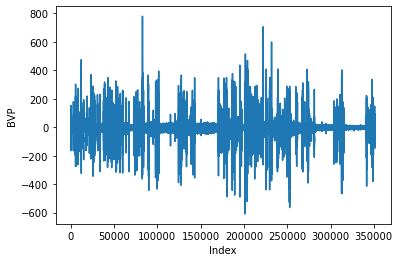

In [59]:
x = bvp_df.index
y = np.array(bvp_df['BVP'])
plt.plot(x, y)
plt.xlabel('Index')
plt.ylabel('BVP')

In [61]:
y_detrend = scipy.signal.detrend(y)

In [64]:
print(y)
print(y_detrend)

[10.17 12.04 13.01 ... 57.59 65.93 69.86]
[10.16143209 12.03143214 13.00143219 ... 57.59766437 65.93766442
 69.86766447]


(0.0, 200.0)

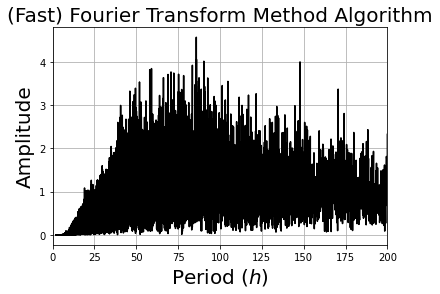

In [66]:
FFT =np.fft.fft(y)
new_N=int(len(FFT)/2) 
f_nat=1
new_X = np.linspace(10**-12, f_nat/2, new_N, endpoint=True)
new_Xph=1.0/(new_X)
FFT_abs=np.abs(FFT)
plt.plot(new_Xph,2*FFT_abs[0:int(len(FFT)/2.)]/len(new_Xph),color='black')
plt.xlabel('Period ($h$)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=20)
plt.grid(True)
plt.xlim(0,200)

# Upsampling and matching signals

In [274]:
# Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))


In [277]:
data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
df.index = [(1 / 64) * i for i in range(len(df))]
df.index = pd.to_datetime(df.index, unit='s')
df_new = df.join(label_df)
df_bfill = df_new.copy()
df_new['label'] = df_new['label'].fillna(method='ffill')
df_new.reset_index(drop=True, inplace=True)


        BVP       EDA       ACC_x       ACC_y         ACC_z       TEMP  label
0     10.17  0.349215  107.000000 -105.000000  1.270000e+02  33.130000    0.0
1     12.04  0.325576  102.356872 -113.012765  1.126363e+02  33.223713    0.0
2     13.01  0.305809   67.000000  -52.000000  4.500000e+01  33.302211    0.0
3     13.07  0.289995   32.736815   17.606782 -5.830147e+00  33.365191    0.0
4     12.33  0.278123   26.000000   40.000000 -3.202097e-14  33.412692    0.0
...     ...       ...         ...         ...           ...        ...    ...
1915   5.47  0.358221   14.513470  -75.934280  1.440351e+01  33.155813    0.0
1916   6.91  0.358469   13.000000  -73.000000  1.400000e+01  33.156445    0.0
1917   7.69  0.358720   12.394525  -69.947345  1.378235e+01  33.157210    0.0
1918   7.81  0.358969   12.000000  -67.000000  1.300000e+01  33.158080    0.0
1919   7.34  0.359214   11.060886  -62.381661  1.114435e+01  33.159022    0.0

[1920 rows x 7 columns]
        BVP       EDA       ACC_x      

/var/folders/3k/sjklqbj91hg9fgb_kbwpy1p40000gn/T/ipykernel_19543/762352639.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


        BVP       EDA      ACC_x      ACC_y     ACC_z       TEMP  label
384   -3.39  0.340260  36.000000 -67.000000  4.000000  33.160000    0.0
385   -6.19  0.339409  37.633402 -65.712846  5.626309  33.161631    0.0
386   -8.86  0.338521  37.000000 -65.000000  7.000000  33.162952    0.0
387  -11.38  0.337625  33.516862 -64.610272  7.234897  33.163870    0.0
388  -13.90  0.336746  30.000000 -64.000000  7.000000  33.164306    0.0
...     ...       ...        ...        ...       ...        ...    ...
2299  14.22  0.361952  10.301177 -61.992709  9.776405  33.176910    0.0
2300  11.46  0.361967  11.000000 -62.000000  9.000000  33.177365    0.0
2301   8.12  0.361980  11.747223 -62.586723  7.794711  33.177924    0.0
2302   4.48  0.361991  12.000000 -63.000000  7.000000  33.178566    0.0
2303   0.85  0.362000  11.610942 -62.410286  6.786519  33.179267    0.0

[1920 rows x 7 columns]
        BVP       EDA      ACC_x      ACC_y      ACC_z       TEMP  label
400    5.99  0.333865  23.000000 -57.0

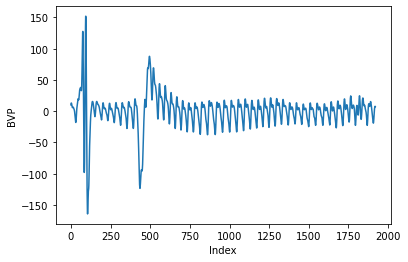

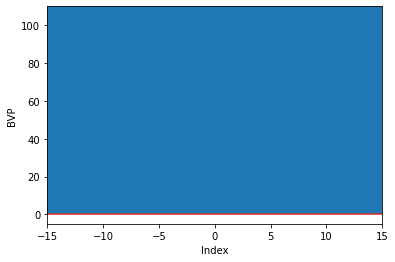

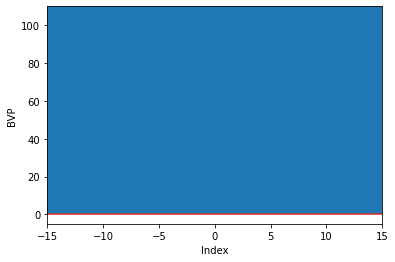

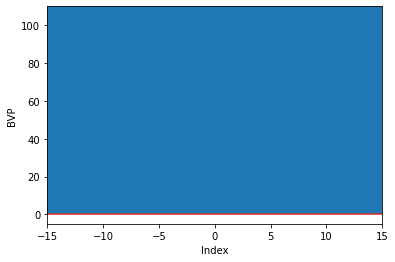

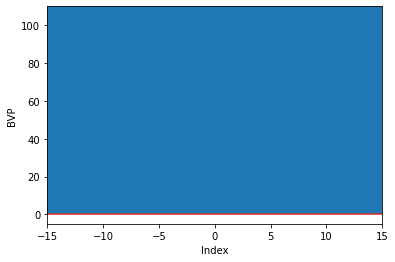

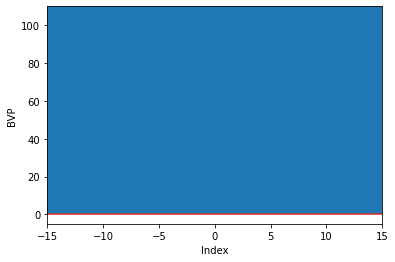

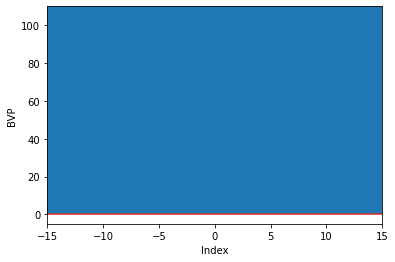

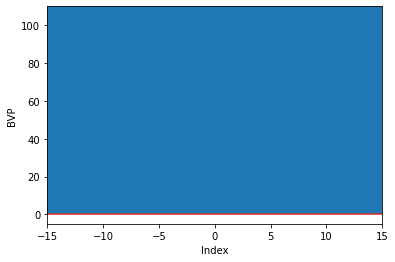

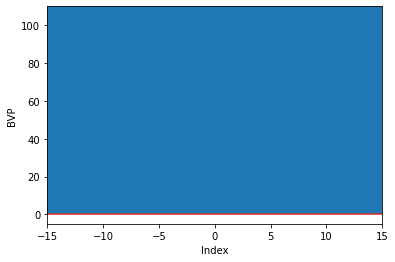

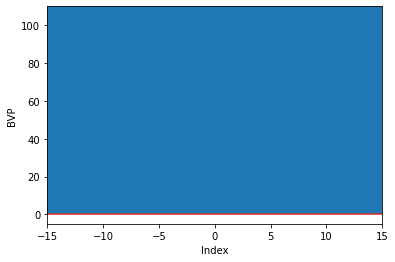

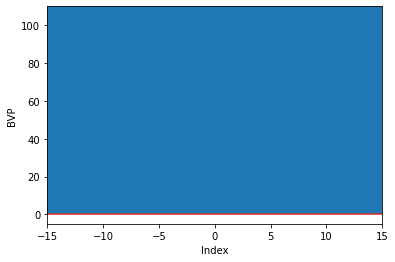

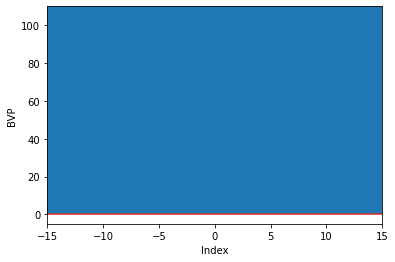

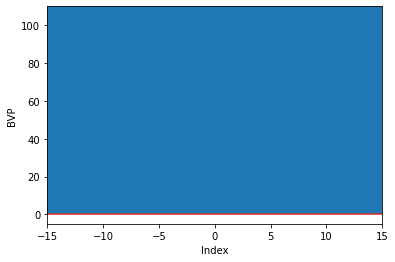

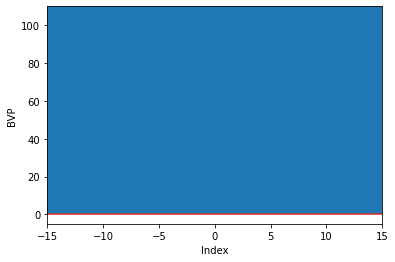

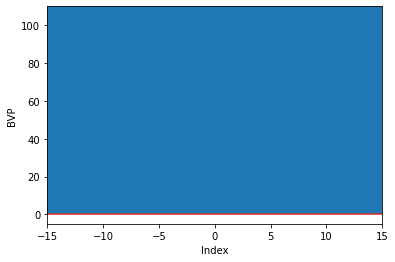

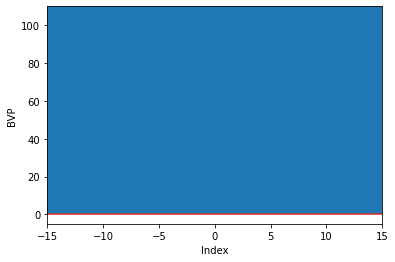

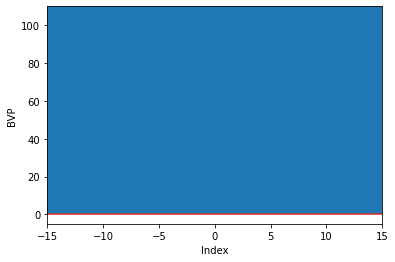

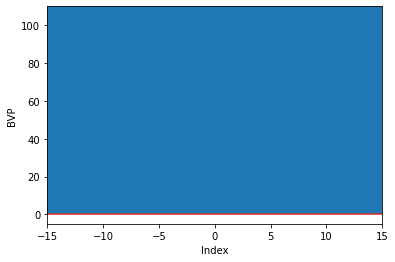

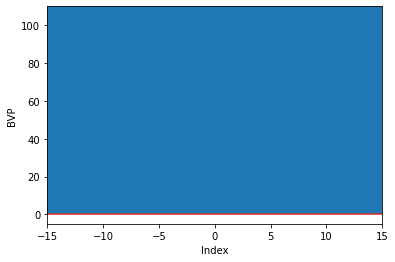

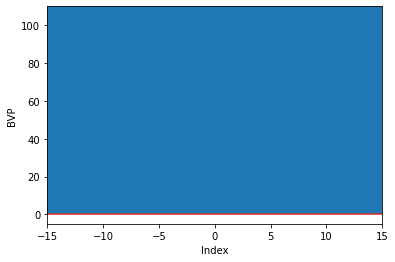

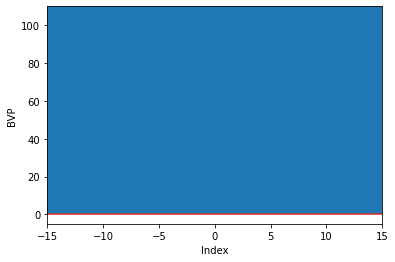

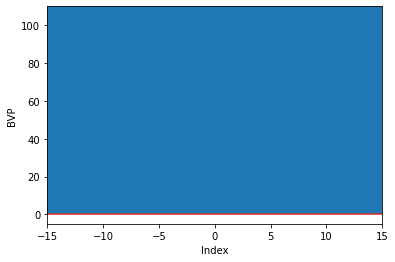

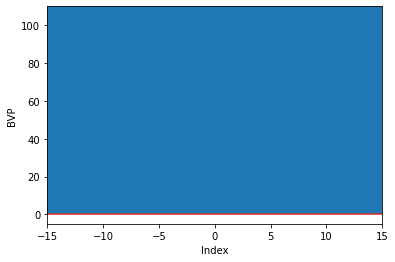

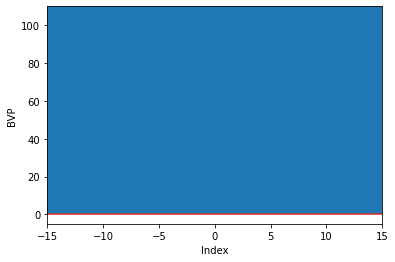

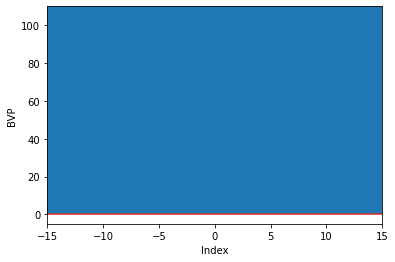

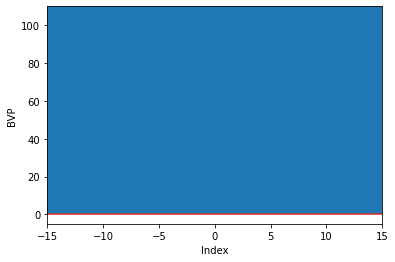

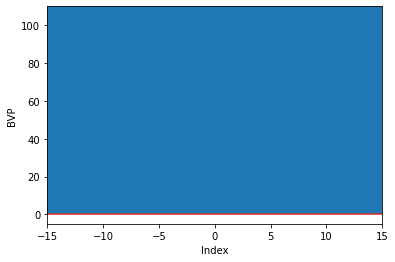

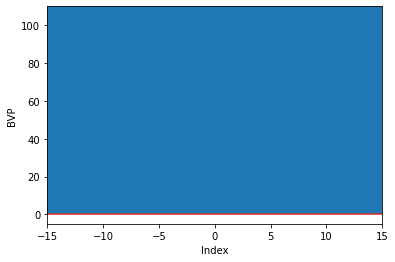

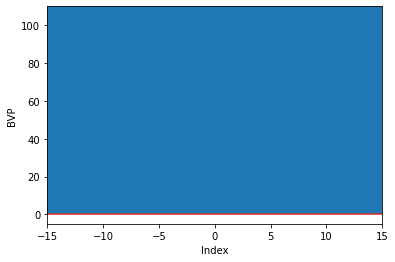

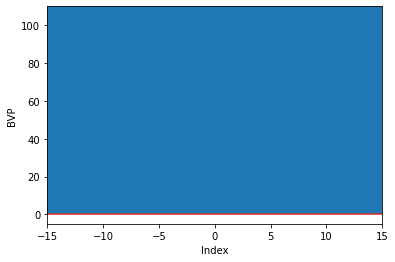

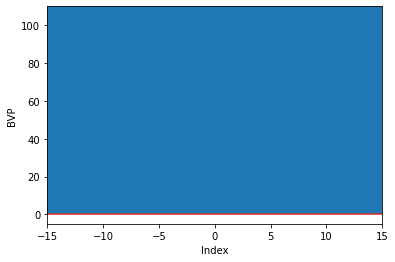

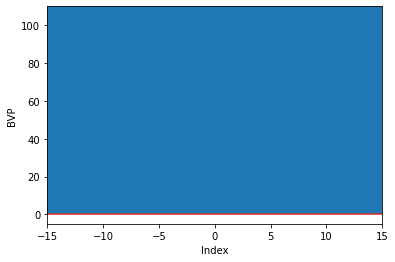

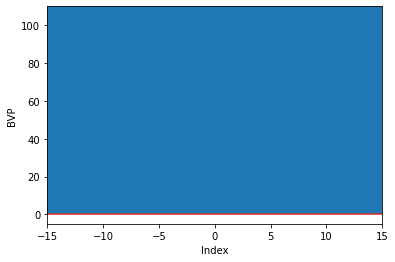

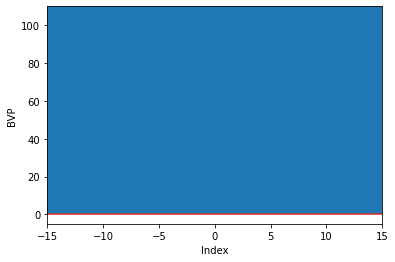

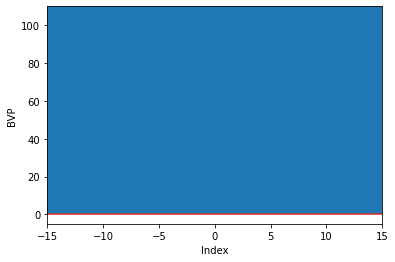

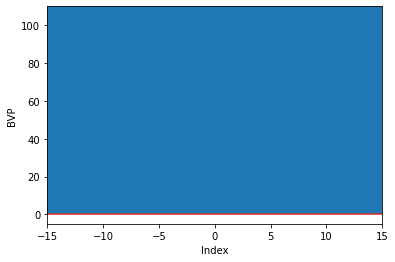

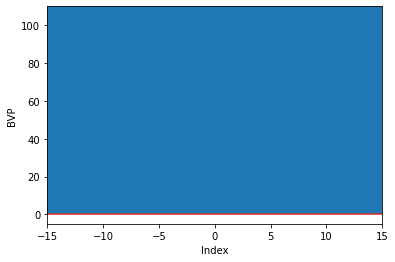

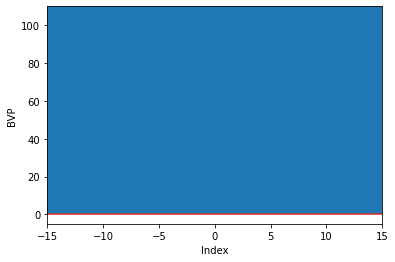

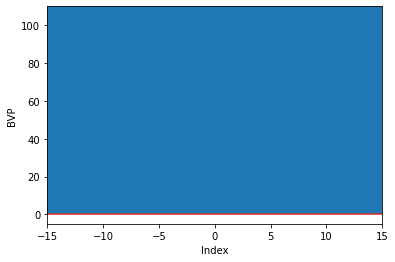

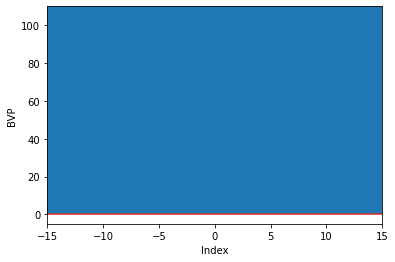

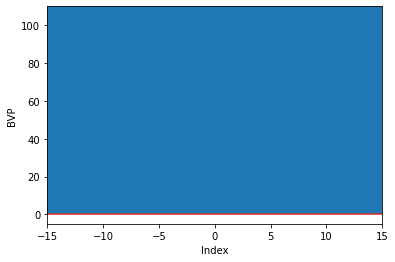

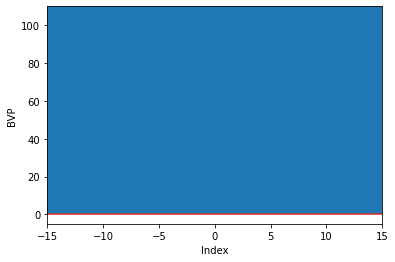

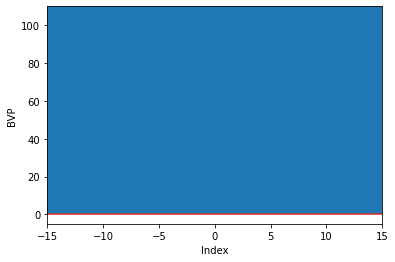

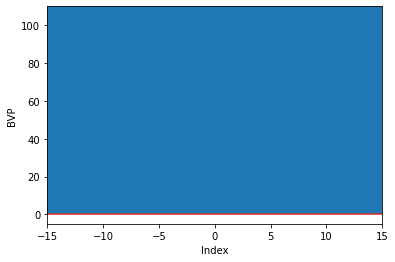

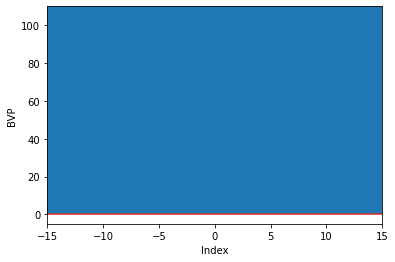

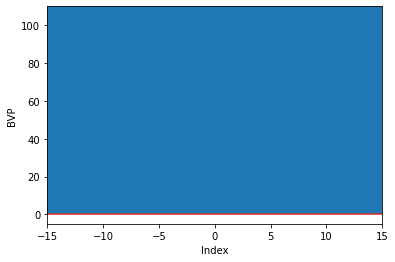

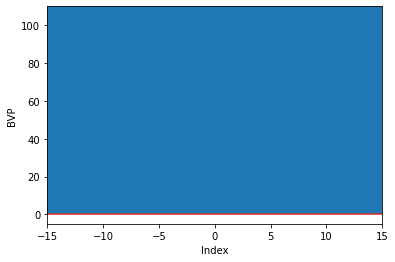

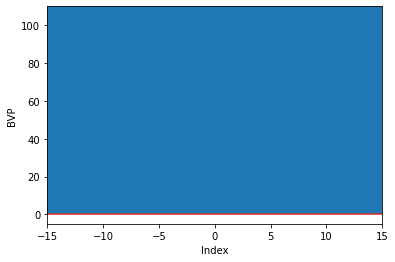

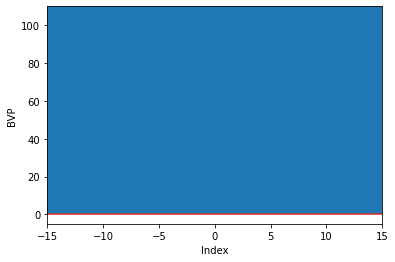

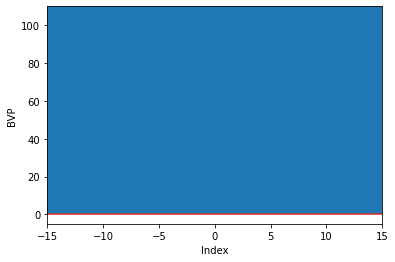

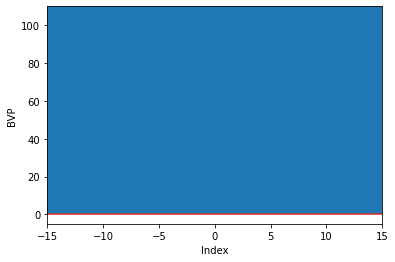

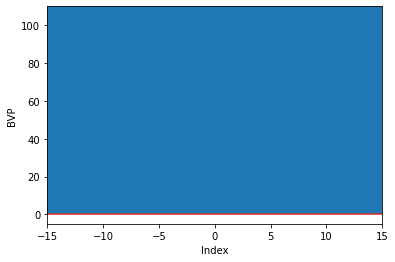

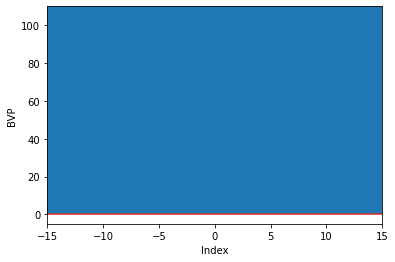

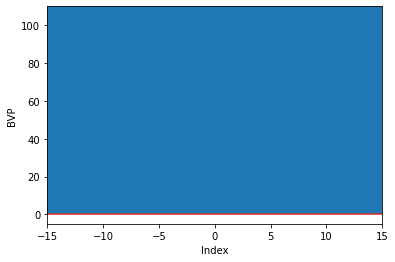

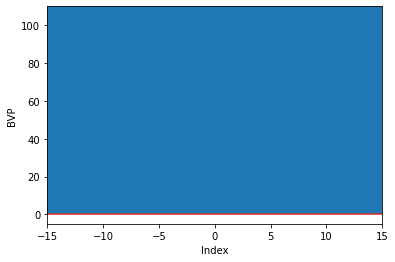

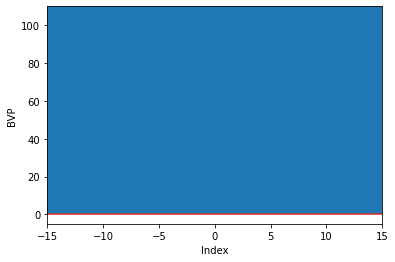

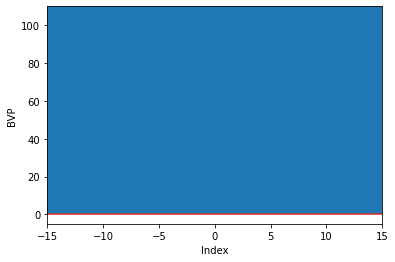

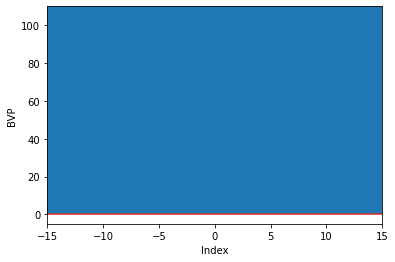

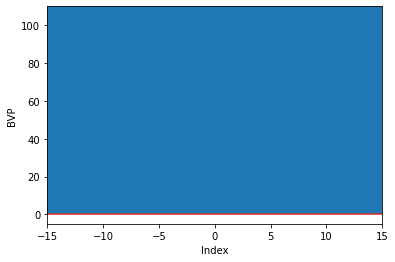

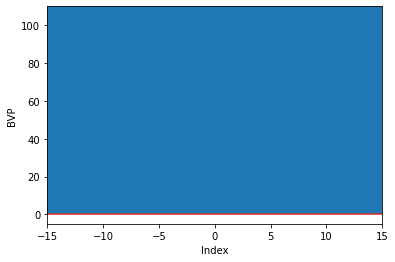

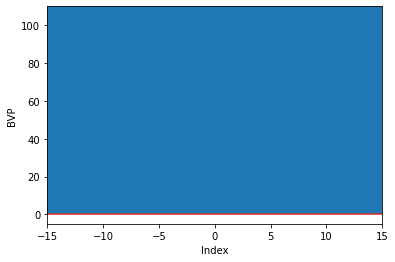

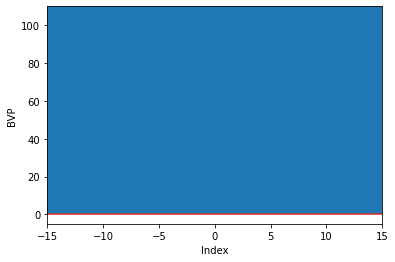

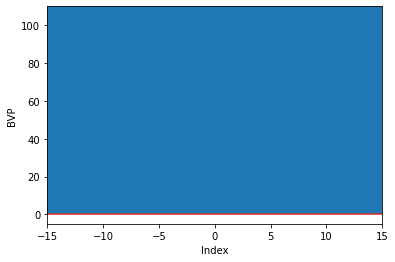

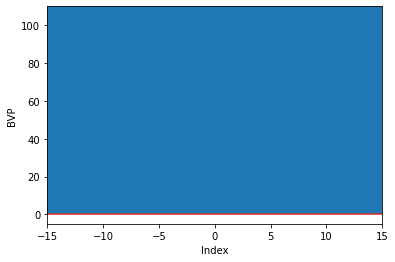

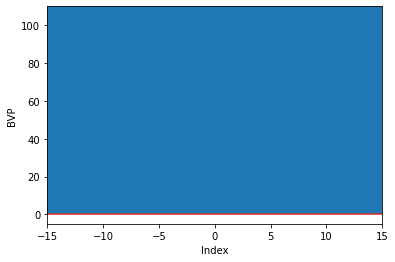

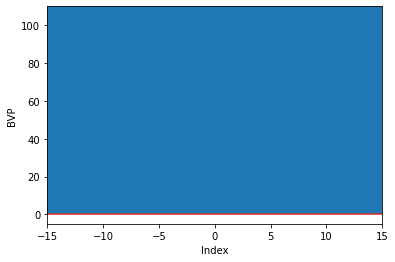

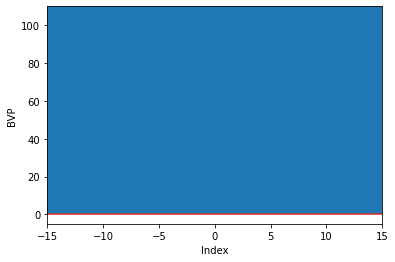

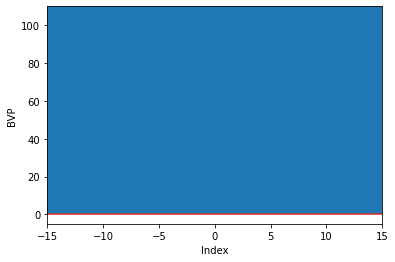

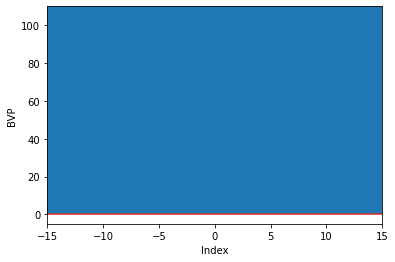

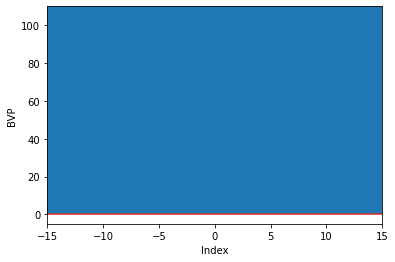

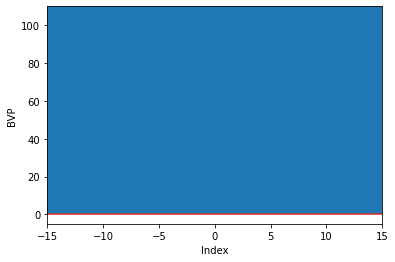

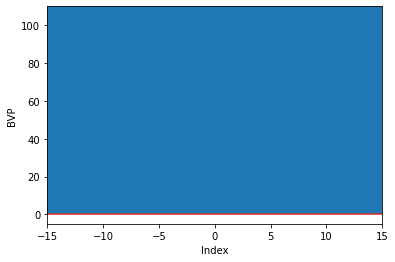

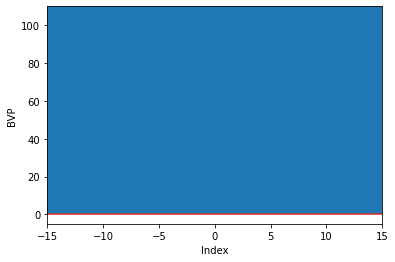

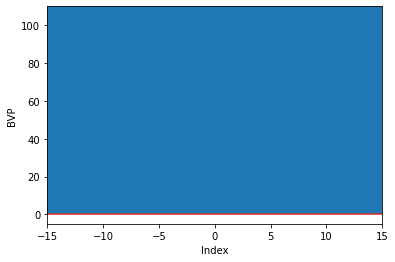

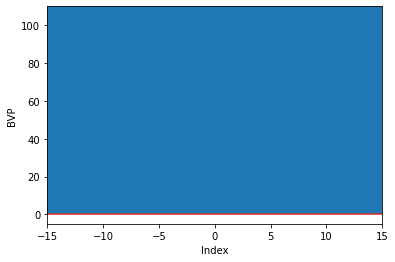

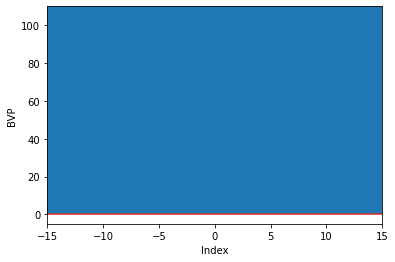

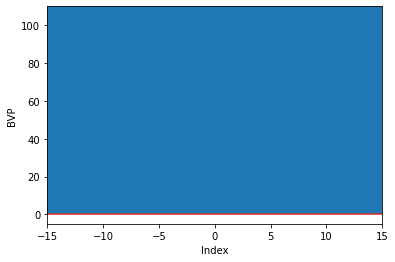

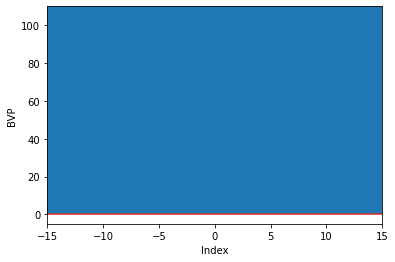

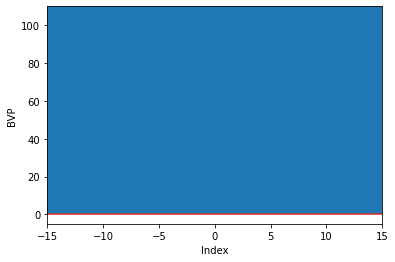

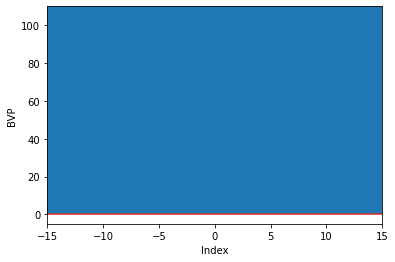

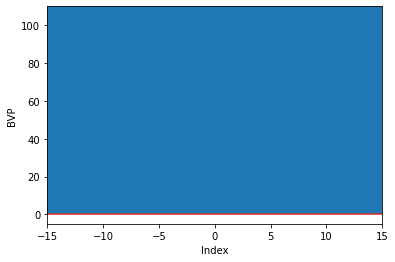

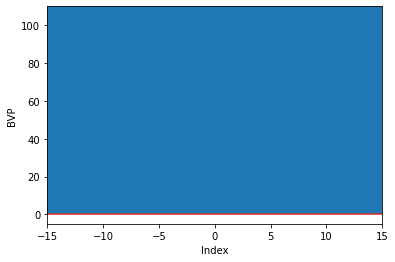

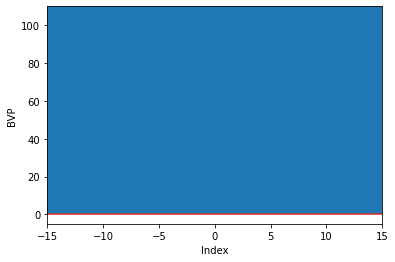

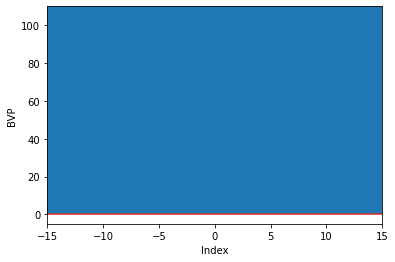

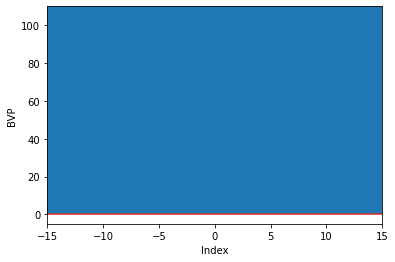

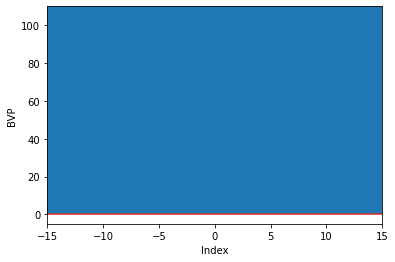

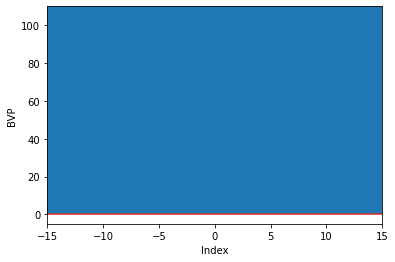

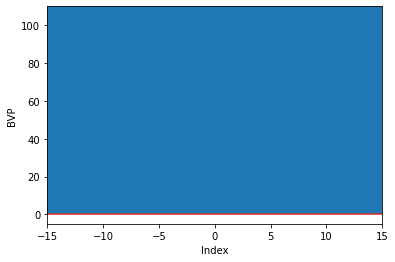

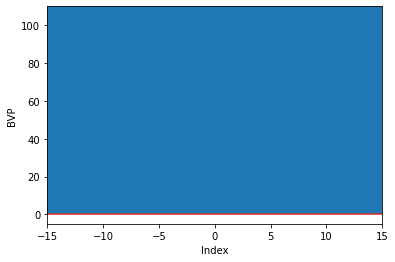

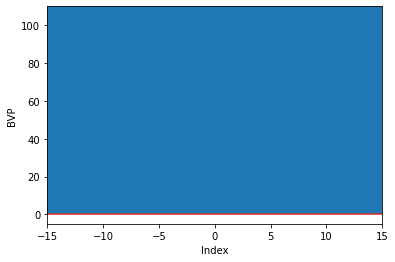

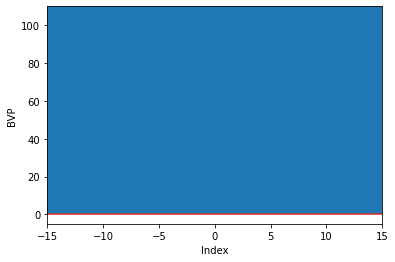

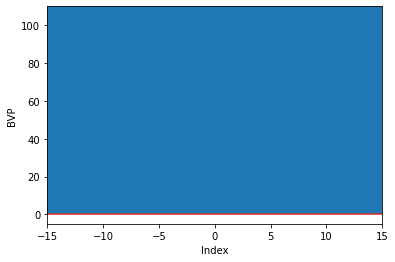

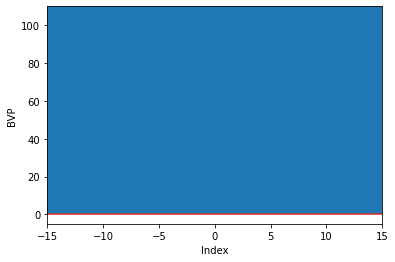

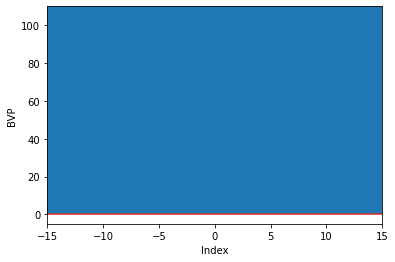

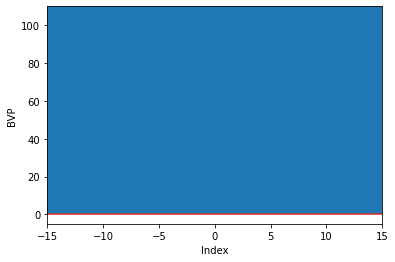

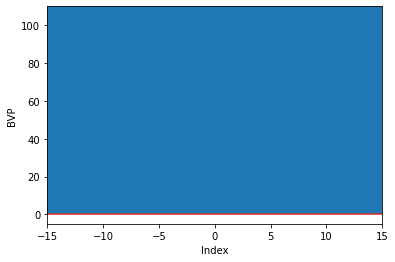

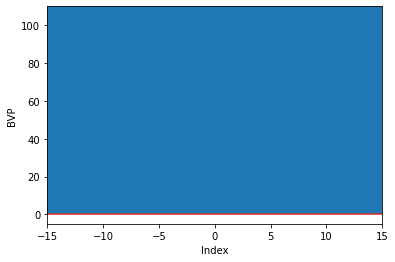

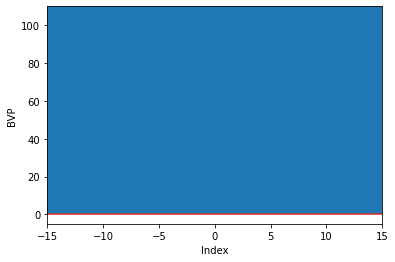

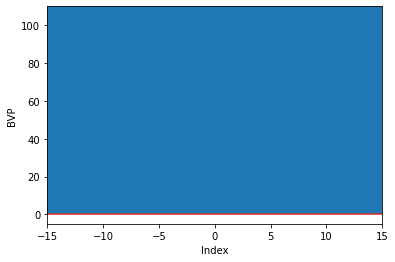

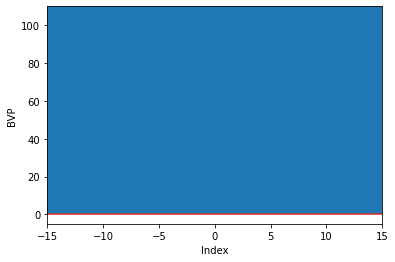

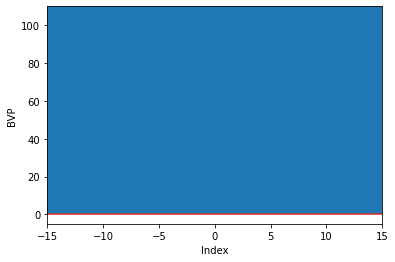

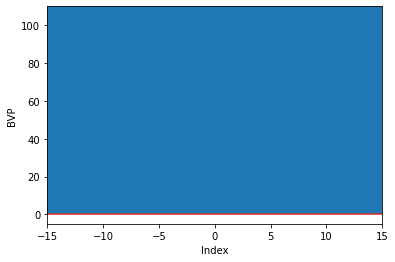

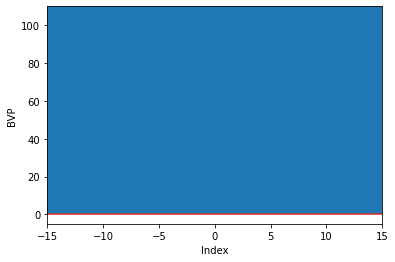

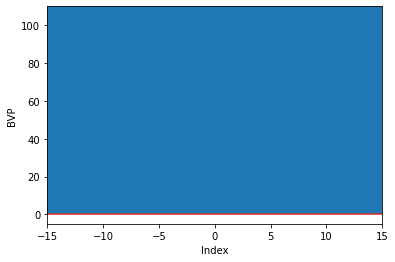

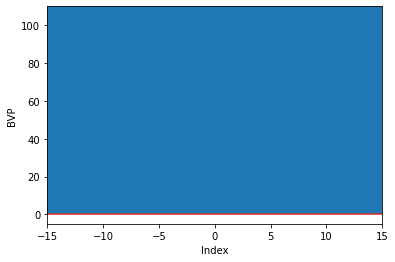

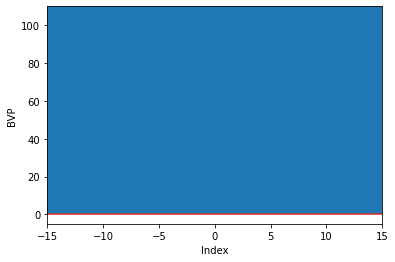

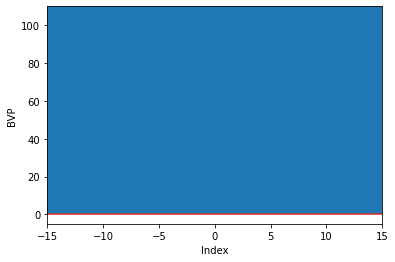

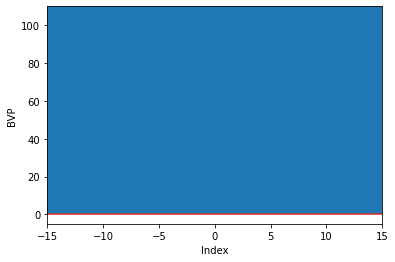

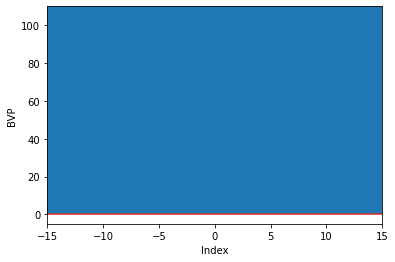

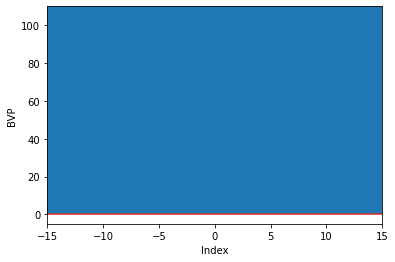

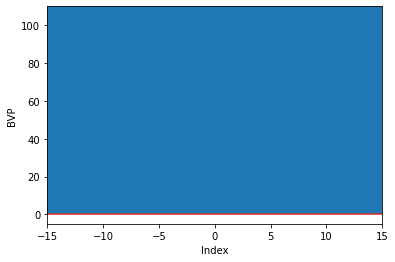

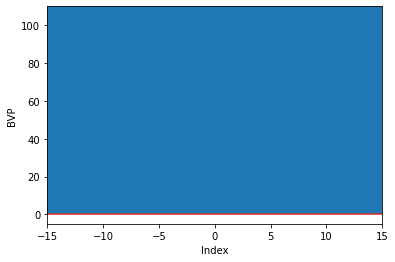

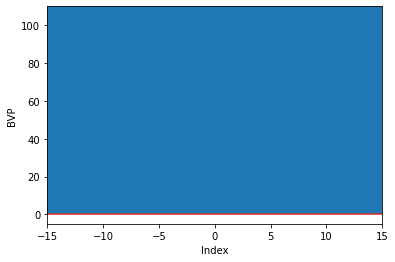

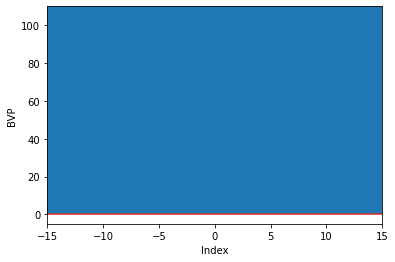

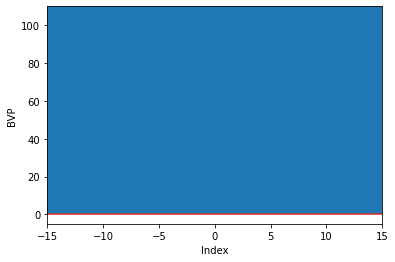

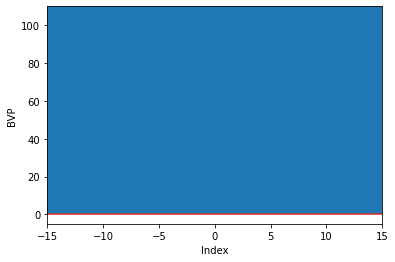

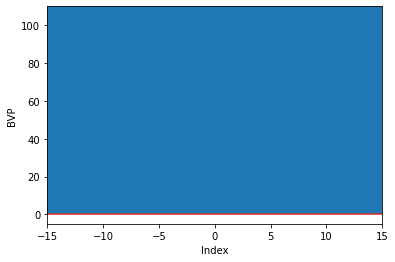

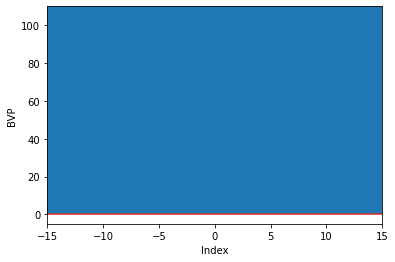

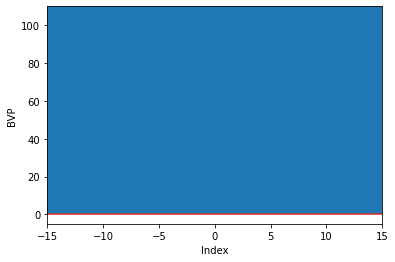

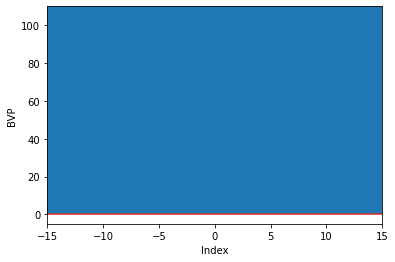

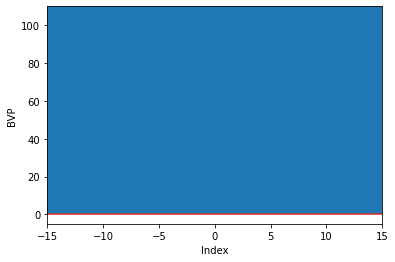

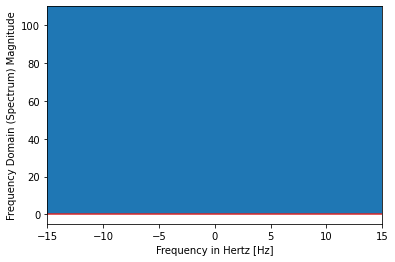

In [343]:
window_len = 64 * 60 # fs = 64 and window length in seconds = 60
subwindow_len = 64 * 30 # fs = 64 and sub-window length in seconds = 7
window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25

window = df_new[:window_len]
windows = []

for i in range(0, window_len, window_shift):
    if i+subwindow_len <= window_len:
        windows.append(df_new[i:i+subwindow_len])
        # print(i,i+subwindow_len)
        subwindow = df_new[i:i+subwindow_len]
        print(subwindow)

        x = subwindow.index
        y = np.array(subwindow['BVP'])
        plt.plot(x, y)
        plt.xlabel('Index')
        plt.ylabel('BVP')
        # y = scipy.fft(subwindow['BVP'].to_numpy())
        # freq = scipy.fftfreq(8, 0.125)
        f_s = 30

        X = scipy.fft.fft(x)
        freqs = scipy.fft.fftfreq(len(x)) * f_s

        fig, ax = plt.subplots()

        ax.stem(freqs, np.abs(X))
        ax.set_xlabel('Frequency in Hertz [Hz]')
        ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
        ax.set_xlim(-f_s / 2, f_s / 2)
        ax.set_ylim(-5, 110)
        # FFT =scipy.fft.fft(y)
        # new_N= len(FFT)//2
        # f_nat=1
        # new_X = np.linspace(10**-12, f_nat/2, new_N, endpoint=True)
        # new_Xph=1.0/(new_X)
        # FFT_abs=np.abs(FFT)
        # plt.plot(new_Xph,2*FFT_abs[0:len(FFT)//2]/len(new_Xph),color='black')
        # plt.xlabel('Period ($h$)',fontsize=20)
        # plt.ylabel('Amplitude',fontsize=20)
        # plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=20)
        # plt.grid(True)
        # plt.xlim(0,200)

### Labels

- 0 = not defined / transient
- 1 = baseline
- 2 = stress
- 3 = amusement
- 4 = meditaiton
- 5/6/7 = should be ignored in this dataset

In [ ]:
# replace all labels 
df[df['label'] == 1]

#### Todos
- Upsample Signals to 64 Hz
- downsample Labels to 64 Hz (Binning?)